# eKYc Dewarping Algorithm

We introduce a new algorithm that is capable of segmenting and dewarping several document types (ID-Cards and Passports) which is based on the intuitions we have about these documents. The algorithm depends on multiple features, basically:
* Foreground Information (Text in id-cards, and MRZ in passports)
* Edge Information
* Color Information
* Structural Information

For example, an id-card has edges that form a closed boundary that is either a rectangle or a round-rectangle and contains text and similar colored areas. We will convert these intuitions into a robust algorithm that can segment the required document.


## First: ID-Card Segmentation

### Text Detection
As a pre-processing step we first have to resize the image. Mainly, we resize the maximum side length of the image to a standard length while preserving the aspect ratio.

To detect the text on the ID-card we perform the following steps:
1. Convert the image of the ID-card to Grayscale.
2. Apply a smoothing filter such as a Gaussian filter.
3. We apply BlackHat morphology (which is closing followed by subtraction). This removes the background and keeps the text.
4. We apply a Sobel operator both in the horizontal and vertical directions to obtain the gradient, and then we take the magnitude of this gradient. This step weakens the background intensities and makes the text intensities strogner. 
$$G = \sqrt{G_x^2 + G_y^2}$$
5. Finally to separate the foreground from the background, we apply the OTSU threshold.

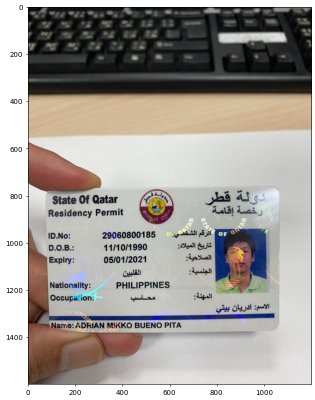

In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 50

id_card_image = cv2.imread('sample.jpg')
plt.imshow(cv2.cvtColor(id_card_image, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
import numpy as np

EPSILON = 1e-6

def resize_image_by_factor(image: np.ndarray, factor: float, interpolation: int) -> np.ndarray:
    if abs(factor - 1.0) < EPSILON:
        return image
    image = cv2.resize(image,
                       (0, 0),
                       fx=factor,
                       fy=factor,
                       interpolation=interpolation)
    return image

def otsu_threshold(image_gray: np.ndarray) -> np.ndarray:
    return cv2.threshold(image_gray,
                         0,
                         255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def edge_detection_gray(gray_image: np.ndarray) -> np.ndarray:
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_x = np.abs(sobel_x)

    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_y = np.abs(sobel_y)

    gradients = np.hypot(sobel_x, sobel_y)
    min_gradients = np.min(gradients)
    max_gradients = np.max(gradients)

    gradients = (gradients - min_gradients) / (max_gradients - min_gradients) * 255
    return gradients.astype(np.uint8)

def text_detection(image: np.ndarray) -> np.ndarray:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    black_hat_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    gray_image = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, black_hat_kernel)
    edges = edge_detection_gray(gray_image)

    return otsu_threshold(edges)

target_max_side_length = 1500
max_side_length = np.max(id_card_image.shape)
resize_factor = target_max_side_length / max_side_length
resized_id_card_image = resize_image_by_factor(id_card_image, resize_factor, cv2.INTER_CUBIC)
detected_text = text_detection(resized_id_card_image)

plt.imshow(detected_text, plt.cm.gray)
plt.show()

As you see, we have succeeded with separating the text from the background; however, there are still some noise and unwanted components. To remove unwanted components, we perform several morphological operations and connected component analysis.

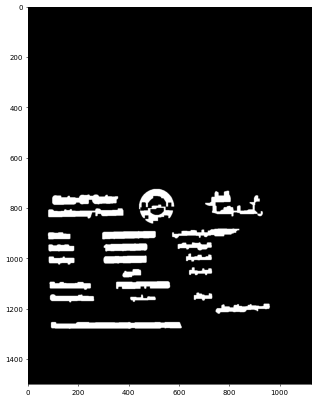

In [3]:
def remove_noise(binary_image: np.ndarray, criteria) -> np.ndarray:
    labels_count, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 8, cv2.CV_32S)
    new_image = np.zeros_like(binary_image)
    for i in range(1, labels_count):
        if criteria(stats[i, :]):
            continue
        new_image[labeled_image == i] = 255
    return new_image

text_detection_min_area = 20
text_detection_max_width_ratio = 0.25
text_detection_max_height_ratio = 0.25
text_detection_max_area_to_image_area_ratio = 0.005
text_detection_closing_kernel_size = 5
text_detection_closing_kernel_iterations = 3
text_detection_closed_min_area_to_image_area_ratio = 0.025
text_detection_opening_kernel_size = 5
text_detection_opening_kernel_iterations = 1
text_detection_opened_min_height_ratio = 0.05
text_detection_opened_min_width_ratio = 0.05
text_detection_final_closing_kernel_size = 7
text_detection_final_closing_kernel_iterations = 1

image_size = (detected_text.shape[1], detected_text.shape[0])
image_area = np.prod(image_size)

detected_text = remove_noise(detected_text,
                             lambda stats: stats[-1] < text_detection_min_area or
                                           stats[2] / image_size[0] > text_detection_max_width_ratio or 
                                           stats[3] / image_size[1] > text_detection_max_height_ratio or
                                           stats[-1] / image_area > text_detection_max_area_to_image_area_ratio)

detected_text = cv2.morphologyEx(detected_text,
                                 cv2.MORPH_CLOSE,
                                 np.ones((text_detection_closing_kernel_size,
                                          text_detection_closing_kernel_size), np.uint8),
                                 iterations=text_detection_closing_kernel_iterations)

detected_text = remove_noise(detected_text,
                             lambda stats: stats[-1] / np.prod(
                                 image_size) > text_detection_closed_min_area_to_image_area_ratio)

detected_text = cv2.morphologyEx(detected_text,
                                 cv2.MORPH_OPEN,
                                 np.ones((text_detection_opening_kernel_size,
                                          text_detection_opening_kernel_size), np.uint8),
                                 iterations=text_detection_opening_kernel_iterations)

detected_text = remove_noise(detected_text,
                             lambda s: s[2] / image_size[0] < text_detection_opened_min_width_ratio and
                                       s[3] / image_size[1] < text_detection_opened_min_height_ratio)

detected_text = cv2.morphologyEx(detected_text,
                                 cv2.MORPH_CLOSE,
                                 np.ones((text_detection_final_closing_kernel_size,
                                          text_detection_final_closing_kernel_size), np.uint8),
                                 iterations=text_detection_final_closing_kernel_iterations)

plt.imshow(detected_text, plt.cm.gray)
plt.show()

This way, we obtain a binary image roughly containing the text areas. Sometimes, some parts are erased or some areas are missing but this is OK since we only depend on this information to detect where the ID-card roughly is and we don't really need the exact text but just "enough" of it.

### Edge Detection
Now we go back to the resized version of the original image and we detect the edges by performing a Sobel operator in both the horizontal and vertical directions on each channel independently. Afterwards, we combine the edge information from each channel by taking the maximum absolute value of the edges accross all three channels at each point in the image. Finally, we calculate the maginutudes of the gradients as before.
Note that the value $\sigma_x = 1.2$ in the Gaussian filter is a well known value for edge detection. Also, we tested it on multiple samples to verify this.

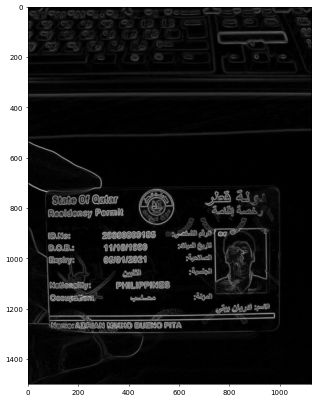

In [4]:
def edge_detection(image: np.ndarray,
                   edge_kernel_size: int = 5,
                   gaussian_blur_kernel: int = 5) -> np.ndarray:
    image = cv2.GaussianBlur(image, (gaussian_blur_kernel, gaussian_blur_kernel), 1.2)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=edge_kernel_size)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=edge_kernel_size)
    
    sobel_x = np.max(np.abs(sobel_x), axis=-1)
    sobel_y = np.max(np.abs(sobel_y), axis=-1)
    
    gradients = np.hypot(sobel_x, sobel_y)
    min_gradients = np.min(gradients)
    max_gradients = np.max(gradients)
    gradients = (gradients - min_gradients) / (max_gradients - min_gradients) * 255
    return gradients.astype(np.uint8)

edge_detection_kernel_size = 5
edge_detection_smoothing_kernel_size = 7

gradients = edge_detection(resized_id_card_image,
                           edge_detection_kernel_size,
                           edge_detection_smoothing_kernel_size)

plt.imshow(gradients, plt.cm.gray)
plt.show()

### Edge Hysteresis
Similar to the Canny algorithm, we will perform edge hysteresis that will yield fewer edges than appilying a simple threshold. However, we will not perform non-maximum supression before this step which is the key difference between our method and the Canny algorithm. For more on the Canny algorithm and edge hysteresis, follow this [link](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).

The Hysteresis algorithm contains two steps:
1. Determine the high & low thresholds (double thresholding) to determine the strong and weak edges.
2. Grow the strong edges by adding weak edges that are connected to the strong edges.

The high threshold is chosen to be the OTSU threshold of the magnitudes of the gradients that are non-zero and not foreground (text) gradients. If it is below a certain value $h_0$, then it is replaced by $h_0$. 
$$h = \max(\text{OTSU_threshold}, h_0)$$

The low threshold is determined by performing a search (binary search) in a certain interval $\left[l_0, \frac{h}{2} \right]$ such that after performing edge hysteresis there is a contour that contains the maximum number of pixels of the text binary image obtained by the previous step.

Note that since $h$ is always greater than or equal $h_0$, then the interval $\left[l_0, \frac{h}{2} \right]$ always contains $\frac{h_0}{2}$ and this ensures that the interval is not too small and not too large as well.

Just to speed up the search, we reduce the size of the text binary image and the gradients by half as a pre-processing step.

low threshold: 7
high threshold: 50


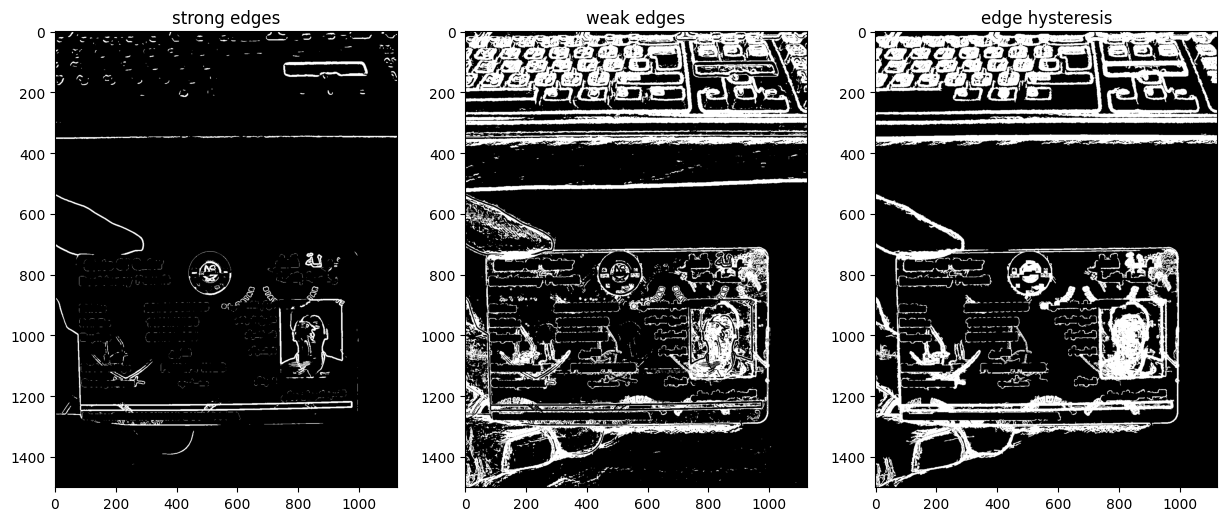

In [5]:
from typing import Tuple
import math

def otsu_threshold_value(image_gray: np.ndarray) -> int:
    return cv2.threshold(image_gray,
                         0,
                         255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]

def perform_hysteresis_on_edge(strong_edges: np.ndarray,
                               weak_edges: np.ndarray,
                               start_point: Tuple[int, int],
                               visits_matrix: np.ndarray) -> None:
    queue = [start_point]

    while len(queue) > 0:
        parent = queue.pop(0)
        visits_matrix[parent[1], parent[0]] = 1

        for dy in range(-1, 2):
            for dx in range(-1, 2):
                x, y = parent
                x += dx
                y += dy
                if x < 0 or x >= strong_edges.shape[1]:
                    continue
                if y < 0 or y >= strong_edges.shape[0]:
                    continue
                if visits_matrix[y, x] == 1:
                    continue
                if weak_edges[y, x] > 0 and (x, y) not in queue:
                    queue.append((x, y))
                    strong_edges[y, x] = 255

def perform_hysteresis(strong_edges: np.ndarray, weak_edges: np.ndarray) -> np.ndarray:
    matrix_shape = (int(strong_edges.shape[0]), int(strong_edges.shape[1]))
    visits_matrix = np.zeros(matrix_shape, np.uint8)

    for y in range(strong_edges.shape[0]):
        for x in range(strong_edges.shape[1]):
            if visits_matrix[y, x] == 0 and strong_edges[y, x] == 255:
                perform_hysteresis_on_edge(strong_edges,
                                           weak_edges,
                                           (x, y),
                                           visits_matrix)

    return strong_edges

def edge_hysteresis(edges: np.ndarray, high_threshold: int, low_threshold: int) -> np.ndarray:
    strong_edges = np.array(edges)
    strong_edges[strong_edges < high_threshold] = 0
    strong_edges[strong_edges >= high_threshold] = 255

    weak_edges = np.array(edges)
    weak_edges[strong_edges == 255] = 0
    weak_edges[weak_edges <= low_threshold] = 0

    return perform_hysteresis(strong_edges, weak_edges)

def close_edges(edges: np.ndarray, kernel_size: int, iterations: int = 1) -> np.ndarray:
    result = cv2.morphologyEx(edges,
                              cv2.MORPH_CLOSE,
                              np.ones((1, kernel_size), np.uint8),
                              iterations=iterations)
    result = cv2.morphologyEx(result,
                              cv2.MORPH_CLOSE,
                              np.ones((kernel_size, 1), np.uint8),
                              iterations=iterations)

    return result

def calculate_hysteresis_score(gradients: np.ndarray,
                               threshold: int,
                               foreground_mask: np.ndarray,
                               foreground_pixels_count: int,
                               high_threshold: int,
                               contour_area_cutoff_area_ratio: float = 0.05,
                               edge_closing_kernel_size: int = 3) -> float:
    edges = edge_hysteresis(gradients,
                            high_threshold,
                            threshold)
    closed_edges = edges
    if edge_closing_kernel_size > 0:
        closed_edges = close_edges(edges,
                                   edge_closing_kernel_size,
                                   1)

    contours, hierarchy = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_score = 0.0
    for contour in contours:
        contour_area = cv2.moments(contour)['m00']
        if contour_area < contour_area_cutoff_area_ratio * np.prod(edges.shape):
            continue

        contour_area_mask = np.zeros(closed_edges.shape[0:2], np.uint8)
        cv2.fillPoly(contour_area_mask, pts=[contour], color=255)
        contour_area_mask = cv2.dilate(contour_area_mask, np.ones((3, 3), np.uint8))
        masked_foreground_pixels_count = np.count_nonzero(foreground_mask[contour_area_mask == 255] == 255)

        if masked_foreground_pixels_count == foreground_pixels_count:
            return 1.0

        foreground_ratio = masked_foreground_pixels_count / foreground_pixels_count
        if foreground_ratio > max_score:
            max_score = foreground_ratio

    return max_score

def low_hysteresis_threshold_binary_search(gradients: np.ndarray,
                                           foreground_mask: np.ndarray,
                                           high_threshold: int,
                                           min_low_threshold: int = 4,
                                           contour_area_cutoff_area_ratio: float = 0.05,
                                           edge_closing_kernel_size: int = 3,
                                           epsilon=1e-7) -> int:
    max_low_threshold = high_threshold
    foreground_pixels_count = np.count_nonzero(foreground_mask == 255)

    score1 = calculate_hysteresis_score(gradients,
                                        min_low_threshold,
                                        foreground_mask,
                                        foreground_pixels_count,
                                        high_threshold,
                                        contour_area_cutoff_area_ratio,
                                        edge_closing_kernel_size)
    score2 = calculate_hysteresis_score(gradients,
                                        max_low_threshold,
                                        foreground_mask,
                                        foreground_pixels_count,
                                        high_threshold,
                                        contour_area_cutoff_area_ratio,
                                        edge_closing_kernel_size)
    if abs(score1 - score2) < epsilon:
        return max_low_threshold

    thresh1 = min_low_threshold
    thresh2 = max_low_threshold

    while (thresh2 - thresh1) > 1:
        thresh = (thresh1 + thresh2) // 2
        score = calculate_hysteresis_score(gradients,
                                           thresh,
                                           foreground_mask,
                                           foreground_pixels_count,
                                           high_threshold,
                                           contour_area_cutoff_area_ratio,
                                           edge_closing_kernel_size)

        if abs(score - score1) < epsilon:
            thresh1 = thresh
            score1 = score
        else:
            thresh2 = thresh
            score2 = score

    if abs(score1 - score2) < epsilon:
        return thresh2

    return thresh1

extraction_resize_factor = 0.5
min_low_threshold = 4
min_high_threshold = 50
contour_area_cutoff_area_ratio = 0.05

high_threshold = otsu_threshold_value(gradients[(gradients > 0) & (detected_text == 0)])
high_threshold = max(high_threshold, min_high_threshold)

resized_detected_text = resize_image_by_factor(detected_text,
                                               extraction_resize_factor,
                                               cv2.INTER_NEAREST)

resized_gradients = resize_image_by_factor(gradients,
                                           extraction_resize_factor,
                                           cv2.INTER_AREA)

low_threshold = low_hysteresis_threshold_binary_search(resized_gradients,
                                                       resized_detected_text,
                                                       int(math.ceil(high_threshold / 2)),
                                                       min_low_threshold,
                                                       contour_area_cutoff_area_ratio)

gradients[detected_text == 255] = 0
edges = edge_hysteresis(gradients,
                        high_threshold,
                        low_threshold)

print(f'low threshold: {low_threshold}')
print(f'high threshold: {high_threshold}')

strong_edges = np.array(gradients)
strong_edges[strong_edges >= high_threshold] = 255
strong_edges[strong_edges < high_threshold] = 0

weak_edges = np.array(gradients)
weak_edges[strong_edges == 255] = 0
weak_edges[weak_edges >= low_threshold] = 255
weak_edges[weak_edges < low_threshold] = 0

mpl.rcParams['figure.figsize'] = [15, 15]
mpl.rcParams['figure.dpi'] = 100

fig, axs = plt.subplots(1, 3)

axs[0].imshow(strong_edges, plt.cm.gray)
axs[0].set_title('strong edges')

axs[1].imshow(weak_edges, plt.cm.gray)
axs[1].set_title('weak edges')

axs[2].imshow(edges, plt.cm.gray)
axs[2].set_title('edge hysteresis')

plt.show()

mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 50

Now, we close the gaps between edges by performing an edge closing operation. Two closing morphological operations are applied, one with a height of one pixel and one with a width of one pixel. The result afterwards may be somewhat extreme but this image will only be used to find a contour that encloses the edges we are interested in and then we want to fill that contour to obtain a mask. Also, in some cases gaps exist in an edge and without performing a closing operation, we will not be able to find such contour.

In [6]:
edge_closing_kernel_size = 43
edge_closing_iterations = 1

closed_edges = close_edges(edges,
                           edge_closing_kernel_size,
                           edge_closing_iterations)

plt.imshow(closed_edges, plt.cm.gray)
plt.show()

Before we search for the required contour, we perform a pre-processing step on the images we obtained by padding each image by black pixels on each side. This will make room for some later operations. Also, we convert the resized version of the original image to the LUV color representation to use it for calculating some color statistics which has better properties than the RGB color representation for our use case.

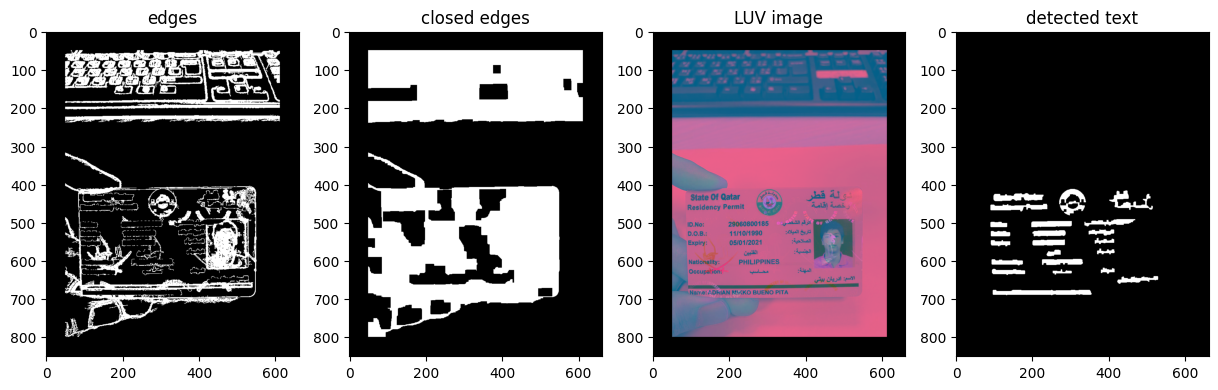

In [7]:
def pad_image(image: np.ndarray, padding_width: int) -> np.ndarray:
    if len(image.shape) < 3:
        return np.pad(image,
                      ((padding_width, padding_width), (padding_width, padding_width)),
                      'constant',
                      constant_values=((0, 0), (0, 0)))

    channels = []
    for i in range(image.shape[-1]):
        image_i = image[:, :, i]
        image_i = np.pad(image_i,
                         ((padding_width, padding_width), (padding_width, padding_width)),
                         'constant',
                         constant_values=((0, 0), (0, 0)))
        channels.append(image_i)

    return np.dstack(tup=tuple(channels))

padding_width = 50

edges = resize_image_by_factor(edges, extraction_resize_factor, cv2.INTER_NEAREST)
edges = pad_image(edges, padding_width)
closed_edges = resize_image_by_factor(closed_edges, extraction_resize_factor, cv2.INTER_NEAREST)
closed_edges = pad_image(closed_edges, padding_width)
image_luv = cv2.cvtColor(resized_id_card_image, cv2.COLOR_BGR2LUV)
image_luv = resize_image_by_factor(image_luv, extraction_resize_factor, cv2.INTER_AREA)
image_luv = pad_image(image_luv, padding_width)
detected_text = resized_detected_text
detected_text = pad_image(detected_text, padding_width)

mpl.rcParams['figure.figsize'] = [15, 15]
mpl.rcParams['figure.dpi'] = 100

fig, axs = plt.subplots(1, 4)

axs[0].imshow(edges, plt.cm.gray)
axs[0].set_title('edges')

axs[1].imshow(closed_edges, plt.cm.gray)
axs[1].set_title('closed edges')

axs[2].imshow(image_luv)
axs[2].set_title('LUV image')

axs[3].imshow(detected_text, plt.cm.gray)
axs[3].set_title('detected text')

plt.show()

mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 50

We look for the contours in the closed edges image and we filter out the small contours according to their areas.

In [8]:
vertices_score_pairs = []
text_pixels_count = np.count_nonzero(detected_text)
contours, hierarchy = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

selected_contours = []
for contour in contours:
    contour_area = cv2.moments(contour)['m00']
    if contour_area < contour_area_cutoff_area_ratio * np.prod(edges.shape):
        continue
    selected_contours.append(contour)

In the real implementation, we loop through all the selected contours and try to segment the ID-card; however, since we already know which contour is the best and for demonstration purposes, we will only continue working with the first contour.

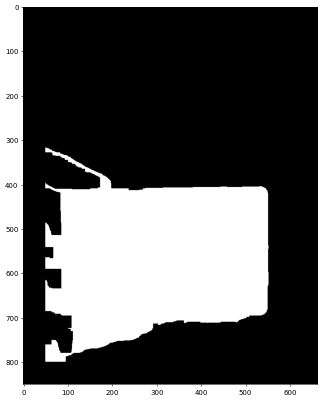

In [9]:
contour = selected_contours[0]

contour_area_mask = np.zeros(closed_edges.shape, np.uint8)
cv2.fillPoly(contour_area_mask, pts=[contour], color=255)

plt.imshow(contour_area_mask, plt.cm.gray)
plt.show()

To get a better mask for ID-card extraction, we take the filled contour and remove the edges from it so we can separate the candidate areas from each other and then select the areas that form the ID-card mask.

In [10]:
candidate_areas_mask = (contour_area_mask == 255) & ~(edges == 255)

plt.imshow(candidate_areas_mask, plt.cm.gray)
plt.show()

### Color Segmentation
In order to obtain the required mask, we start by selecting the best candidate area by performing connected component analysis and choosing the connected component that contains the maximum number of text pixels. Also, we store the color statistics of this region.

mean luv: [174.96375476  96.11904192 138.57968447]
std luv: [53.23154002  2.44499746  6.8268382 ]
number of pixels: 83542


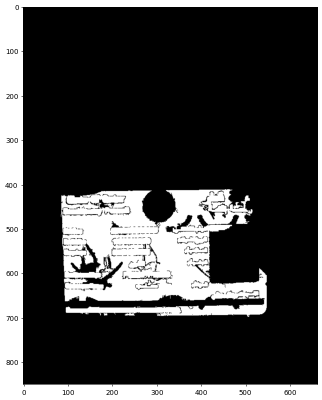

In [11]:
(labels_count,
 labeled_connected_components,
 components_stats,
 centroids) = cv2.connectedComponentsWithStats(candidate_areas_mask.astype(np.uint8),
                                               8,
                                               cv2.CV_32S)

best_label = 0
best_region_area = 0
best_region_text_score = 0
mask_area = candidate_areas_mask.shape[0] * candidate_areas_mask.shape[1]
candidate_best_area_cutoff_area_ratio = 0.025

for label in range(0, labels_count):
    region_area = components_stats[label, -1]
    if region_area < candidate_best_area_cutoff_area_ratio * mask_area:
        continue
    label_mask = labeled_connected_components == label
    if np.count_nonzero(candidate_areas_mask[label_mask]) == 0:
        continue
    text_score = np.count_nonzero(candidate_areas_mask[label_mask]) / text_pixels_count
    if best_region_text_score < text_score:
        best_region_area = region_area
        best_region_text_score = text_score
        best_label = label
    elif best_region_text_score == text_score and best_region_area < region_area:
        best_region_area = region_area
        best_region_text_score = text_score
        best_label = label

best_region_mask = labeled_connected_components == best_label
mu1 = np.mean(image_luv[best_region_mask], axis=0)
sigma1 = np.std(image_luv[best_region_mask], axis=0)
n1 = np.count_nonzero(best_region_mask)

print(f'mean luv: {mu1}')
print(f'std luv: {sigma1}')
print(f'number of pixels: {n1}')

plt.imshow(best_region_mask, plt.cm.gray)
plt.show()

Now we filter out the connected components by choosing only similar colored areas. To do this, we use a statistical distance measure called the Fisher Distance and a fixed threshold. We do that on each color channel of the LUV representation and then take the maximum distance across the channels. Given $\mu_1, \sigma_1, n_1$ of the first region, and $\mu_2, \sigma_2, n_2$ of the second region, the Fisher Distance between the two regions is defined by:

$$d = \frac{\lvert \mu_1 - \mu_2 \rvert}{\sigma_{12}}$$

where $\sigma_{12}$ is the combined standard deviation of $\sigma_1$ and $\sigma_2$, i.e.:

$$ \sigma_{12} = \sqrt{\frac{n_1 \sigma_1 + n_2 \sigma_2}{n_1 + n_2}} $$

Hence, 

$$d = \frac{\sqrt{n_1 + n_2} \lvert \mu_1 - \mu_2 \rvert}{\sqrt{n_1 \sigma_1 + n_2 \sigma_2}}$$

We set $\mu_1, \sigma_1, n_1$ to be the statistics of the previously selected region.

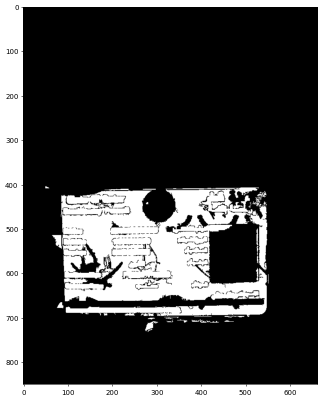

In [12]:
min_candidate_area_pixels = 20
region_colors_distance_threshold = 1.75

labels = []

for label in range(0, labels_count):
    if components_stats[label, -1] < min_candidate_area_pixels:
        continue

    region_mask = labeled_connected_components == label
    n = np.count_nonzero(candidate_areas_mask[region_mask])
    if n == 0:
        continue

    if image_luv.size == 0:
        continue

    mu = np.mean(image_luv[region_mask], axis=0)
    sigma = np.std(image_luv[region_mask], axis=0)

    sigma_mask = (sigma1 < EPSILON) & (sigma < EPSILON)
    if np.any(sigma_mask):
        mu_mask = (np.abs(mu1 - mu) > EPSILON) & sigma_mask
        if np.any(mu_mask):
            fischer_distance = 1000.0
        else:
            fischer_distance = 0.0
    else:
        nominator = np.sqrt(n1 + n) * np.abs(mu1 - mu)
        denominator = np.sqrt(n1 * sigma1 ** 2 + n * sigma ** 2)
        fischer_distance = nominator / denominator
        fischer_distance = np.max(fischer_distance)

    if fischer_distance < region_colors_distance_threshold:
        labels.append((label, region_mask))
        
chosen_labels = labels

result_mask = np.zeros_like(closed_edges)
for _, region_mask in labels:
    result_mask[region_mask] = 255

plt.imshow(result_mask, plt.cm.gray)
plt.show()

Another filtering operation is performed on the connected components of similar color where we only choose the regions that contain text. Furthermore, a convex hull of the combined regions is calculated.

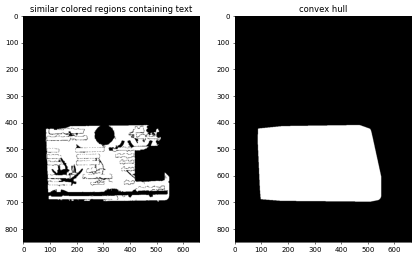

In [13]:
from scipy.spatial import ConvexHull

colors_mask = np.zeros(detected_text.shape, np.uint8)
all_vertices = []
filtered_labels = []

for i in range(len(chosen_labels)):
    label, region_mask = chosen_labels[i]

    if np.count_nonzero(detected_text[region_mask]) == 0:
        continue

    try:
        convex_hull = ConvexHull(np.transpose(np.where(np.transpose(region_mask))))
    except:
        continue

    colors_mask[region_mask] = 255
    final_convex_hull_vertices = [convex_hull.points[v] for v in convex_hull.vertices]

    all_vertices.extend(final_convex_hull_vertices)
    filtered_labels.append(label)

final_convex_hull = ConvexHull(all_vertices)
final_convex_hull_vertices = [final_convex_hull.points[v] for v in final_convex_hull.vertices]

fig, axs = plt.subplots(1, 2)

axs[0].imshow(colors_mask, plt.cm.gray)
axs[0].set_title('similar colored regions containing text')

final_convex_hull_filled = np.zeros_like(closed_edges)
cv2.fillPoly(final_convex_hull_filled, [np.array(final_convex_hull_vertices, np.int32)], 255)

axs[1].imshow(final_convex_hull_filled, plt.cm.gray)
axs[1].set_title('convex hull')

plt.show()

Now we perform one last filtering operation where we only select the similar colored regions that intersect the convex hull by ratio greater than a fixed threshold.

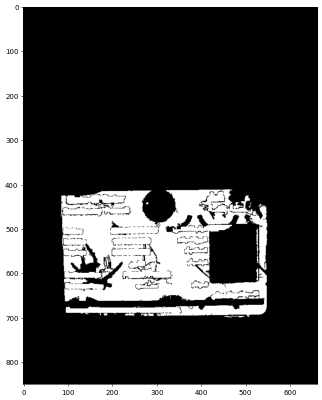

In [14]:
min_candidate_area_intersection_ratio = 0.2

final_convex_region_mask = np.zeros(colors_mask.shape, np.uint8)
cv2.fillPoly(final_convex_region_mask, [np.array(final_convex_hull_vertices, np.int32)], 255)
final_convex_region_mask = final_convex_region_mask == 255

for label, region_mask in chosen_labels:
    if label in filtered_labels:
        continue

    intersecting_pixels_count = np.count_nonzero(np.logical_and(final_convex_region_mask, region_mask))
    intersection_ratio = intersecting_pixels_count / np.count_nonzero(region_mask)
    if intersection_ratio < min_candidate_area_intersection_ratio:
        continue

    colors_mask[region_mask] = 255

plt.imshow(colors_mask, plt.cm.gray)
plt.show()

The final mask is obtained by removing noise and performing a closing operation followed by a dilation.

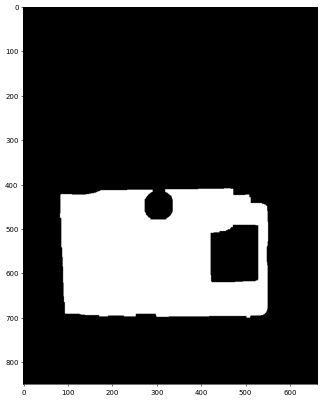

In [15]:
max_noise_size = 200
final_mask_closing_kernel_size = 11
final_mask_closing_iterations = 3
final_mask_dilation_kernel_size = 5

final_mask = remove_noise(colors_mask, lambda stats: stats[-1] <= max_noise_size)
final_mask = cv2.morphologyEx(final_mask,
                              cv2.MORPH_CLOSE,
                              np.ones((final_mask_closing_kernel_size,
                                       final_mask_closing_kernel_size), np.uint8),
                              iterations=final_mask_closing_iterations)
final_mask = cv2.dilate(final_mask,
                        np.ones((final_mask_dilation_kernel_size,
                                 final_mask_dilation_kernel_size), np.uint8))

plt.imshow(final_mask, plt.cm.gray)
plt.show()

### Structural Analysis
Our objective from the beginning was to obtain 4 points (vertices of a 4-polygon) on the image to perform dewarping. However, not always do we obtain a full mask of the ID-Card. In many cases, we obtain a partial mask with some imperfections and holes as in the previous step. To roughly reconstruct the full ID-card mask from this information, we perform some structural analysis on the mask's contour to obtain a 4-polygon.

These are the following steps to approximately reconstruct the full-mask:
1. We apply the [Douglas-Peucker algorithm](http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm) to reduce the number of contour points and to be able to better approximate the 4-polygon of the id-card.
2. We compute the convex hull of the previous step to fill any holes on the boundaries or corners of the mask.
3. We iteratively construct a larger convex polygon with fewer vertices by removing edges and combining/consolidating neighboring edges which minimizes a cost function.

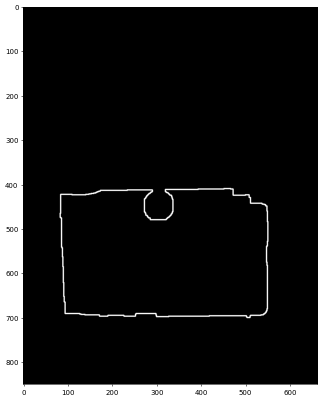

In [16]:
from typing import Union

def find_largest_contour(image: np.ndarray) -> Union[None, np.ndarray]:
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_area = -1
    largest_contour = None
    for contour in contours:
        contour_area = cv2.moments(contour)['m00']
        if contour_area > max_area:
            max_area = contour_area
            largest_contour = contour
    if largest_contour is None:
        return None
    return largest_contour.reshape(-1, 2)

contour_vertices = find_largest_contour(final_mask)

contour_image = np.zeros_like(closed_edges)
cv2.drawContours(contour_image, [contour_vertices], 0, 255, 2)
plt.imshow(contour_image, plt.cm.gray)
plt.show()

#### Douglas-Peucker algorithm

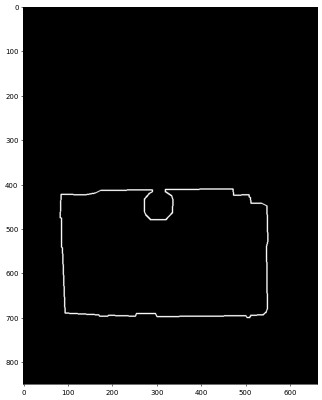

In [17]:
contour_approximation_arc_length_ratio = 0.001
epsilon = contour_approximation_arc_length_ratio * cv2.arcLength(contour_vertices, True)
contour = cv2.approxPolyDP(contour_vertices, epsilon, True).reshape(-1, 2)

contour_image = np.zeros_like(closed_edges)
cv2.drawContours(contour_image, [contour], 0, 255, 2)
plt.imshow(contour_image, plt.cm.gray)
plt.show()

#### Convex Hull

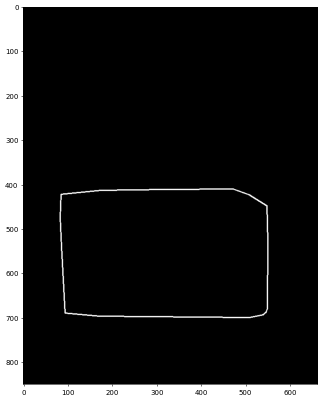

In [18]:
convex_hull = ConvexHull(contour)
contour = np.array([convex_hull.points[i] for i in convex_hull.vertices], np.int32)

contour_image = np.zeros_like(closed_edges)
cv2.drawContours(contour_image, [contour], 0, 255, 2)
plt.imshow(contour_image, plt.cm.gray)
plt.show()

#### Edge combination/consolodation algorithm

To remove unwanted edges and combine/consolodate neighboring edges we loop over all the edges of the convex polygon and compute this cost function:
$$C(e) = \text{area}_2 - \text{area}_1 + \text{min_rotated_rectangle_area}_2 -\text{min_rotated_rectangle_area}_1$$

Where $\text{area}_2$ is the area of the polygon after removing the edge $e$, $\text{area}_1$ is the area of the polygon before removing the edge $e$, $\text{min_rotated_rectangle_area}_2$ is the area of the minimum rotated rectangle enclosing the convex polygon after removing the edge $e$, and $\text{min_rotated_rectangle_area}_1$ is the area of the minimum rotated rectangle enclosing the convex polygon before removing the edge $e$.

If the cost of an edge is negative, we ignore it, otherwise, we take the edge with minimum cost and remove it which removes 2 vertices of the polygon, then we combine/consolidate neighboring edges by computing the intersection point of the two lines created by extending the edges and then add the point to the polygon. This way we reduce the number of vertices of the polygon by 1.

![Example](diagram.jpg)

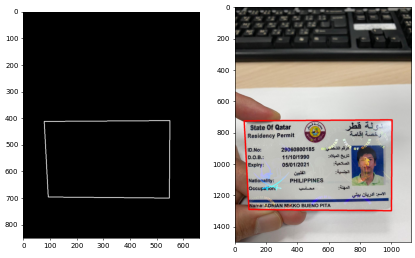

In [19]:
import sys
import shapely.geometry

def adjust_angle_by_quadrant(angle: float,
                             point: tuple[int, int]) -> float:
    x, y = point
    if x < 0 and y > 0:
        return 180 - angle
    if x < 0 and y < 0:
        return 180 + angle
    if x > 0 and y < 0:
        return 360 - angle
    return angle

def compute_angle(origin: np.ndarray,
                  point: np.ndarray) -> float:
    x1 = point[0] - origin[0]
    y1 = origin[1] - point[1]
    if math.fabs(x1) > 1e-6:
        theta = math.fabs(math.atan(y1 / x1)) / math.pi * 180
    else:
        theta = 90
    return adjust_angle_by_quadrant(theta, (x1, y1))

def compute_center_of_gravity(points: np.ndarray) -> np.ndarray:
    return np.array([np.mean(points[:, :1]), np.mean(points[:, 1:])])

def points_to_parametric_line(point1: np.ndarray, point2: np.ndarray) -> np.ndarray:
    (x1, y1) = point1
    (x2, y2) = point2
    return np.array([[x2 - x1, x1],
                     [y2 - y1, y1]], np.float64)

def find_lines_intersection_point(line1: np.ndarray,
                                  line2: np.ndarray) -> Union[None, np.ndarray]:
    if line1 is None or line2 is None:
        return None

    a1_x, b1_x = line1[0]
    a1_y, b1_y = line1[1]

    a2_x, b2_x = line2[0]
    a2_y, b2_y = line2[1]

    mat1 = np.array([[a1_x, -a2_x],
                     [a1_y, -a2_y]], np.float64)
    if np.linalg.det(mat1) == 0:
        return None

    mat2 = np.array([[b2_x - b1_x],
                     [b2_y - b1_y]], np.float64)

    t = np.dot(np.linalg.inv(mat1), mat2).reshape(2)

    point1 = line1[:, 0] * t[0] + line1[:, 1]
    point2 = line2[:, 0] * t[1] + line2[:, 1]

    return (point1 + point2) / 2

def is_parametric_line_vertical(parametric_line: np.ndarray) -> bool:
    a_x, _ = parametric_line[0]
    a_y, _ = parametric_line[1]

    if abs(a_x) <= EPSILON < abs(a_y):
        return True
    else:
        return False

def is_parametric_line_horizontal(parametric_line: np.ndarray) -> bool:
    a_x, _ = parametric_line[0]
    a_y, _ = parametric_line[1]

    if abs(a_y) <= EPSILON < abs(a_x):
        return True
    else:
        return False

def sort_points_clockwise_polygonal(origin: np.array,
                                    points: np.array) -> list:
    point_angle_pairs = [[points[i], compute_angle(origin, points[i])] for i in range(len(points))]
    point_angle_pairs.sort(key=lambda x: x[1], reverse=True)

    i = 0
    n = len(point_angle_pairs)
    while i < n:
        if abs(point_angle_pairs[i][1] - point_angle_pairs[(i + 1) % n][1]) < EPSILON:
            j = 1
            while j < n - 1:
                if abs(point_angle_pairs[(i + j) % n][1] - point_angle_pairs[(i + j + 1) % n][1]) >= EPSILON:
                    j += 1
                    break
                j += 1
            section = [point_angle_pairs[(i + k) % n] for k in range(0, j)]
            section.sort(key=lambda x: scipy.spatial.distance.euclidean(point_angle_pairs[i - 1][0], x[0]))

            if i + j > n:
                point_angle_pairs = section[n - i:] + point_angle_pairs[(i + j) % n:i] + section[:n - i]
            else:
                point_angle_pairs = point_angle_pairs[:i] + section + point_angle_pairs[i + j:]
            i += j - 1
            if i > n:
                break
        i += 1
    return [point for point, _ in point_angle_pairs]

def consolidate_two_vertices_with_minimum_cost(vertices: list) -> Tuple[list, bool]:
    min_positive_area_diff = sys.maxsize
    best_polygon_vertices = vertices
    was_consolidated = False
    vertices_polygon = shapely.geometry.Polygon(vertices)
    vertices_polygon_area = vertices_polygon.area
    vertices_min_polygon_area = vertices_polygon.minimum_rotated_rectangle.area

    for i in range(len(vertices)):
        parametric_line1 = points_to_parametric_line(vertices[i - 1],
                                                     vertices[i])
        parametric_line2 = points_to_parametric_line(vertices[(i + 1) % len(vertices)],
                                                     vertices[(i + 2) % len(vertices)])

        if (is_parametric_line_vertical(parametric_line1) and is_parametric_line_vertical(parametric_line2)) or \
                (is_parametric_line_horizontal(parametric_line1) and is_parametric_line_horizontal(parametric_line2)):
            intersection_point = (np.array(vertices[i - 1]) + np.array(vertices[(i + 2) % len(vertices)])) / 2
        else:
            intersection_point = find_lines_intersection_point(parametric_line1,
                                                               parametric_line2)

        if intersection_point is None:
            continue

        new_polygon_vertices = [p for p in vertices]
        next_i = (i + 1) % len(vertices)
        if next_i > i:
            new_polygon_vertices.pop(next_i)
            new_polygon_vertices.pop(i)
        else:
            new_polygon_vertices.pop(i)
            new_polygon_vertices.pop(next_i)
        new_polygon_vertices.insert(i, intersection_point)

        new_polygon = shapely.geometry.Polygon(new_polygon_vertices)
        area_diff1 = new_polygon.area - vertices_polygon_area
        area_diff2 = new_polygon.minimum_rotated_rectangle.area - vertices_min_polygon_area
        area_diff = area_diff1 + area_diff2
        if area_diff < 0:
            continue

        if area_diff < min_positive_area_diff:
            was_consolidated = True
            min_positive_area_diff = area_diff
            best_polygon_vertices = new_polygon_vertices

    if was_consolidated is False:
        for i in range(len(vertices)):
            new_polygon_vertices = [p for p in vertices]
            new_polygon_vertices.pop(i)

            new_polygon = shapely.geometry.Polygon(new_polygon_vertices)
            area_diff = new_polygon.area - vertices_polygon_area
            if area_diff < 0:
                continue

            if area_diff < min_positive_area_diff:
                was_consolidated = True
                min_positive_area_diff = area_diff
                best_polygon_vertices = new_polygon_vertices

    return best_polygon_vertices, was_consolidated

def try_consolidate_polygon_points(polygon_vertices: np.ndarray, target_points: int) -> list:
    polygon_vertices = np.array(polygon_vertices)
    polygon_vertices = sort_points_clockwise_polygonal(compute_center_of_gravity(polygon_vertices), polygon_vertices)
    best_polygon = polygon_vertices
    while len(best_polygon) > target_points:
        best_polygon, was_consolidated = consolidate_two_vertices_with_minimum_cost(best_polygon)
        if not was_consolidated:
            break

    return best_polygon

polygon_4_vertices = try_consolidate_polygon_points(contour, 4)
polygon_4_vertices = np.array(polygon_4_vertices, np.int32)
polygon_image = np.zeros_like(closed_edges)
resized_copy = cv2.cvtColor(resized_id_card_image, cv2.COLOR_BGR2RGB)
cv2.drawContours(polygon_image, [polygon_4_vertices], 0, 255, 2)
cv2.drawContours(resized_copy, [(polygon_4_vertices - np.array([50, 50])) * 2], 0, (255, 0, 0), 7)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(polygon_image, plt.cm.gray)
axs[1].imshow(resized_copy)
plt.show()

The 4-polygon above is a really good approximation of the ID-card boundary; however, there is still another possibility where the generated ID-card mask is more accurate as depicted in this picture:

![Mask](mask-image.bmp)

Which is almost a convex shape and this makes it easier to find the 4 corner points as we see below.

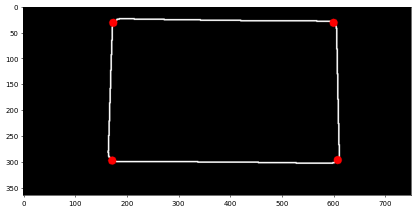

In [20]:
from typing import Callable

def distance(point1: np.ndarray,
             point2: np.ndarray) -> float:
    return np.sqrt(np.sum(np.square(np.subtract(point1, point2))))

def distance_between_point_and_line(line_initial_point: np.ndarray,
                                    line_terminal_point: np.ndarray,
                                    point: np.ndarray) -> float:
    x1, y1 = line_initial_point
    x2, y2 = line_terminal_point
    x0, y0 = point
    denominator = distance(line_initial_point, line_terminal_point)
    if denominator < EPSILON:
        return distance(line_initial_point, point)
    return abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1)) / denominator

def find_furthest_point_from(point: np.ndarray,
                             points: np.ndarray) -> Tuple[np.ndarray, int]:
    max_distance = -1.0
    furthest_point = None
    furthest_point_index = -1
    for i in range(len(points)):
        p = points[i]
        point_distance = distance(point, p)
        if point_distance > max_distance:
            max_distance = point_distance
            furthest_point = p
            furthest_point_index = i
    return furthest_point, furthest_point_index

def find_point_by_maximality_criteria(points: np.ndarray,
                                      maximality_criteria: Callable[[np.ndarray], float]) -> Tuple[np.ndarray, int]:
    max_value = -1.0
    point_of_max_value = None
    point_index = -1
    for i in range(len(points)):
        p = points[i]
        value = maximality_criteria(p)
        if value > max_value:
            max_value = value
            point_of_max_value = p
            point_index = i
    return point_of_max_value, point_index

def sort_points_clockwise_with_indices(origin: np.array,
                                       points: np.array,
                                       points_indices: list) -> Tuple[list, list]:
    point_angle_pairs = [[points[i], points_indices[i], compute_angle(origin, points[i])] for i in range(len(points))]
    point_angle_pairs.sort(key=lambda x: x[2], reverse=True)
    return [point for point, _, _ in point_angle_pairs], [point_i for _, point_i, _ in point_angle_pairs]

def calculate_triangle_area(point1: np.ndarray,
                            point2: np.ndarray,
                            point3: np.ndarray) -> float:
    return np.fabs(0.5 * (point1[0] * (point2[1] - point3[1])
                          + point2[0] * (point3[1] - point1[1])
                          + point3[0] * (point1[1] - point2[1])))

def calculate_polygon_area(point1: np.ndarray,
                           point2: np.ndarray,
                           point3: np.ndarray,
                           base_point: np.ndarray):
    area1 = calculate_triangle_area(base_point, point1, point2)
    area2 = calculate_triangle_area(base_point, point2, point3)
    return area1 + area2

def find_convex_4_polygon_vertices(points: np.ndarray) -> Tuple[list, list]:
    center = compute_center_of_gravity(points)
    vertex1, vertex1_index = find_furthest_point_from(center, points)
    vertex2, vertex2_index = find_furthest_point_from(vertex1, points)
    vertex3, vertex3_index = find_point_by_maximality_criteria(points,
                                                               lambda p: distance_between_point_and_line(vertex1,
                                                                                                         vertex2,
                                                                                                         p))
    vertices = [vertex1, vertex2, vertex3]
    vertices_indices = [vertex1_index, vertex2_index, vertex3_index]
    vertices, vertices_indices = sort_points_clockwise_with_indices(center, vertices, vertices_indices)
    vertex4, vertex4_index = find_point_by_maximality_criteria(points,
                                                               lambda p: calculate_polygon_area(vertices[0],
                                                                                                vertices[1],
                                                                                                vertices[2],
                                                                                                p))
    return vertices + [vertex4], vertices_indices + [vertex4_index]


mask_image = cv2.imread('mask-image.bmp', cv2.IMREAD_GRAYSCALE)
mask_contour_vertices = find_largest_contour(mask_image)
mask_4_vertices, mask_4_vertices_indices = find_convex_4_polygon_vertices(mask_contour_vertices)

points_image = np.zeros((mask_image.shape[0], mask_image.shape[1], 3), np.uint8)
cv2.drawContours(points_image, [mask_contour_vertices], 0, (255, 255, 255), 2)

for point in mask_4_vertices:
    cv2.circle(points_image, tuple(point), 8, (255, 0, 0), -1)
    
plt.imshow(points_image, plt.cm.gray)
plt.show()

Because of some imperfections in the contour and because of the round corners of the ID-card, we cannot simply take these points and perform dewarping. We should enhance these points by regressing the segments between them by lines and then calculating the intersections of these lines. This is more reliable in any case.

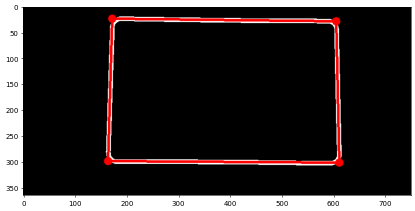

In [21]:
def estimate_line_parameters(n: int, points: np.ndarray, axis: int = 0) -> np.ndarray:
    coefficients = np.array([i + 1 for i in range(n)])

    sum1 = np.sum(points[:, axis] * coefficients)
    sum2 = np.sum(points[:, axis])

    mat1 = np.array([[n * (n + 1) * (2 * n + 1) / 6, n * (n + 1) / 2],
                     [n * (n + 1) / 2, n]], np.float64)

    mat2 = np.array([[sum1],
                     [sum2]], np.float64)

    return np.dot(np.linalg.inv(mat1), mat2).reshape(2)

def parametric_linear_regression(points: np.ndarray) -> Union[None, np.ndarray]:
    n = len(points)

    if n <= 1:
        return None

    parameters1 = estimate_line_parameters(n, points)
    parameters2 = estimate_line_parameters(n, points, 1)

    return np.concatenate((parameters1.reshape(1, 2), parameters2.reshape(1, 2)), axis=0)

def get_contour_segments(contour: np.ndarray,
                         vertices_indices: list) -> list[np.ndarray]:
    contour_list = contour.tolist()
    segments = []
    for i in range(len(vertices_indices)):
        current_i = vertices_indices[i]
        next_i = vertices_indices[(i + 1) % len(vertices_indices)]
        if current_i < next_i:
            segment = np.array(contour_list[next_i:] + contour_list[:current_i], np.float64)
        else:
            segment = np.array(contour_list[next_i:current_i], np.float64)
        segments.append(segment)
    return segments

def enhance_vertices(contour: np.ndarray,
                     vertices_indices: list[int]) -> Union[None, np.ndarray]:
    segments = get_contour_segments(contour, vertices_indices)

    lines = []
    for segment in segments:
        line = parametric_linear_regression(segment)
        if line is None:
            return None
        lines.append(line)

    intersections = []
    for i in range(len(segments)):
        intersection = find_lines_intersection_point(lines[i - 1], lines[i])
        if intersection is None:
            return None
        intersections.append(intersection)

    return np.array(intersections, np.int32)


center_point = compute_center_of_gravity(mask_contour_vertices)
mask_4_vertices, mask_4_vertices_indices = sort_points_clockwise_with_indices(center_point,
                                                                              mask_4_vertices,
                                                                              mask_4_vertices_indices)
mask_4_vertices = enhance_vertices(mask_contour_vertices, mask_4_vertices_indices)

points_image = np.zeros((mask_image.shape[0], mask_image.shape[1], 3), np.uint8)

cv2.drawContours(points_image, [mask_contour_vertices], 0, (255, 255, 255), 7)

cv2.line(points_image, mask_4_vertices[0], mask_4_vertices[1], (255, 0, 0), 3)
cv2.line(points_image, mask_4_vertices[1], mask_4_vertices[2], (255, 0, 0), 3)
cv2.line(points_image, mask_4_vertices[2], mask_4_vertices[3], (255, 0, 0), 3)
cv2.line(points_image, mask_4_vertices[3], mask_4_vertices[0], (255, 0, 0), 3)

for point in mask_4_vertices:
    cv2.circle(points_image, tuple(point), 8, (255, 0, 0), -1)
    
plt.imshow(points_image)
plt.show()


Now the problem is which method should we use for finding the 4 corners? Instead of selecting only one of the two methods, we will always apply them both and then use a scoring system to select the best one. Returning to the previous ID-card example, we would want to see what happens if we apply the second method.

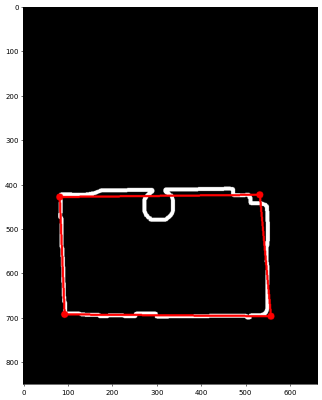

In [22]:
center_point = compute_center_of_gravity(contour_vertices)
contour_4_vertices, contour_4_vertices_i = find_convex_4_polygon_vertices(contour_vertices)
contour_4_vertices, contour_4_vertices_i = sort_points_clockwise_with_indices(center_point,
                                                                              contour_4_vertices,
                                                                              contour_4_vertices_i)
contour_4_vertices = enhance_vertices(contour_vertices, contour_4_vertices_i)

points_image = np.zeros((closed_edges.shape[0], closed_edges.shape[1], 3), np.uint8)

cv2.drawContours(points_image, [contour_vertices], 0, (255, 255, 255), 7)

cv2.line(points_image, contour_4_vertices[0], contour_4_vertices[1], (255, 0, 0), 3)
cv2.line(points_image, contour_4_vertices[1], contour_4_vertices[2], (255, 0, 0), 3)
cv2.line(points_image, contour_4_vertices[2], contour_4_vertices[3], (255, 0, 0), 3)
cv2.line(points_image, contour_4_vertices[3], contour_4_vertices[0], (255, 0, 0), 3)

for point in contour_4_vertices:
    cv2.circle(points_image, tuple(point), 8, (255, 0, 0), -1)
    
plt.imshow(points_image)
plt.show()

As we can clearly see, this is not a better approximation than the result of the first method. To score the two outputs, we will calculate these quantities:

1. Since the area of the 4-polygon should be close to the area of the contour and not be far off, we can use this to calculate a score $s_1$.
2. An estimate of the width-to-height ratio of each 4-polygon should be close to the real ID-Card width-to-height ratio (about 1.575) which will be used to calculate a score $s_2$.
3. If we considered the lines which are the edges of the 4-polygon as linear approximations of the segments of the contours, then we can calculate the error of each approximation and use them to calculate a score $s_3$.
4. The final score is the product of all previous scores $s = s_1 \cdot s_2 \cdot s_3$.

The decision will be carried as follows:
1. If $s_3$ in one of the two outputs was above a certain threshold and their scores were not equal, then the output with the highest $s_3$ will be chosen. 
2. After that, if $s_2$ in one of the two outputs was a above a certain threshold and their scores were not equal, then the output with the highest $s_2$ will be chosen.
3. Finally, we compare $s_1$ for both outputs and the one with the highest score is chosen.
4. We store the output with the score $s$.

In [23]:
from shapely.geometry import Point, Polygon

def estimate_width_to_height_ratio(four_polygon: Polygon) -> float:
    polygon1_coordinates = four_polygon.exterior.coords
    distance1 = Point(polygon1_coordinates[0]).distance(Point(polygon1_coordinates[1]))
    distance2 = Point(polygon1_coordinates[1]).distance(Point(polygon1_coordinates[2]))
    distance3 = Point(polygon1_coordinates[2]).distance(Point(polygon1_coordinates[3]))
    distance4 = Point(polygon1_coordinates[3]).distance(Point(polygon1_coordinates[0]))
    estimated1 = max(distance1, distance3)
    estimated2 = max(distance2, distance4)
    return max(estimated1, estimated2) / min(estimated1, estimated2)

def get_polygon_pixels_count(vertices: np.ndarray, image_shape: Tuple[int, ...]) -> int:
    polygon_area_image = np.zeros(image_shape, np.uint8)
    cv2.fillPoly(polygon_area_image, [vertices], 255)
    return np.count_nonzero(polygon_area_image == 255)

def find_closest_points(target_points: np.ndarray, source_points: np.ndarray) -> list[Tuple[np.ndarray, int]]:
    result = []
    for point in source_points:
        min_distance = sys.float_info.max
        best_target_point = target_points[0]
        best_target_point_i = 0
        for i in range(len(target_points)):
            target_point = target_points[i]
            distance_between_points = Point(point).distance(Point(target_point))
            if distance_between_points < min_distance:
                min_distance = distance_between_points
                best_target_point = target_point
                best_target_point_i = i
        result.append((best_target_point, best_target_point_i))
    return result

def linearity_error(segments: list[np.ndarray],
                    vertices: np.ndarray) -> float:
    total_error = 0
    n = 0
    for i in range(vertices.shape[0]):
        current_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % vertices.shape[0]]
        segment = segments[i]
        for j in range(1, len(segment) - 1):
            total_error += distance_between_point_and_line(current_vertex, next_vertex, segment[j])
            n += 1
    return total_error / n

def calculate_contour_segments_linearity_error(contour: np.ndarray, vertices: np.ndarray) -> float:
    closest_contour_points = find_closest_points(contour,
                                                 vertices)
    segments = get_contour_segments(contour,
                                    [p[1] for p in closest_contour_points])
    return linearity_error(segments, vertices)

def calculate_document_vertices_scores(document_vertices: np.ndarray,
                                       document_mask: np.ndarray,
                                       document_mask_contour_area: int,
                                       document_mask_contour_vertices: np.ndarray,
                                       expected_document_width_height_ratio: float) -> Tuple[float, float, float]:
    if document_vertices is None:
        return 0.0, 0.0, 0.0

    if len(document_vertices) >= 4:
        polygon = Polygon(document_vertices)
        ratio = estimate_width_to_height_ratio(polygon)
        polygon_area = get_polygon_pixels_count(document_vertices, document_mask.shape)
        error = calculate_contour_segments_linearity_error(document_mask_contour_vertices,
                                                           document_vertices)

        area_score = min(polygon_area, document_mask_contour_area) / max(polygon_area, document_mask_contour_area)

        width_height_score = 1.0 - min(1.0,
                                       abs(ratio - expected_document_width_height_ratio) /
                                       expected_document_width_height_ratio)

        edges_linearity_score = 1.0 - min(1.0,
                                          error /
                                          (np.sqrt(document_mask.shape[0] ** 2 + document_mask.shape[1] ** 2) / 8))

        scores = (area_score, width_height_score, edges_linearity_score)
    else:
        scores = (0.0, 0.0, 0.0)

    return scores

_, (width, height), _ = cv2.minAreaRect(contour_vertices)
contour_area = width * height

scores1 = calculate_document_vertices_scores(polygon_4_vertices,
                                             final_mask,
                                             contour_area,
                                             contour_vertices,
                                             1.575)

scores2 = calculate_document_vertices_scores(contour_4_vertices,
                                             final_mask,
                                             contour_area,
                                             contour_vertices,
                                             1.575)

print('First output scores:')
print(scores1)
print(f'final score: {np.prod(scores1)}')
print('\nSecond output scores:')
print(scores2)
print(f'final score: {np.prod(scores2)}')

First output scores:
(0.9839135597207608, 0.9709942038937233, 0.9429473848224769)
final score: 0.9008677577031424

Second output scores:
(0.911476979898202, 0.9276400410137516, 0.9413347237407524)
final score: 0.7959197294464118


As you see, the scores of the first output are higher than the scores of the second output, so obviously it will be chosen. Finally, we translate the points of the 4-polygon by the padding amount and scale them by all the inverses of the resizing factors to obtain the final 4 points that will be used to dewarp the original image. Afterwards, we correct the order of the vertices before dewarping to ensure that the orientation of the sides are correct.

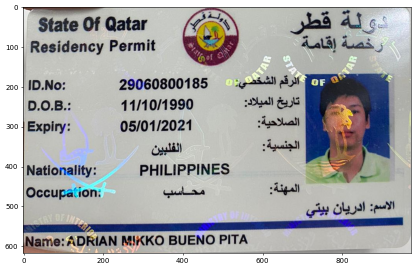

In [24]:
def triangle_area(point1: Tuple[float, float],
                  point2: Tuple[float, float],
                  point3: Tuple[float, float]) -> float:
    x1, y1 = point1
    x2, y2 = point2
    x3, y3 = point3
    return math.fabs(0.5 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)))


def calculate_4_polygon_area(point1: Tuple[float, float],
                             point2: Tuple[float, float],
                             point3: Tuple[float, float],
                             point4: Tuple[float, float]) -> float:
    return triangle_area(point1, point2, point3) + \
           triangle_area(point1, point4, point3)

def estimate_rectangle_width_height_from_vertices(vertices: list[Tuple[float, float]],
                                                  id_card_width_height_ratio: float) -> Tuple[int, int]:
    area = calculate_4_polygon_area(*vertices)
    height = math.sqrt(area / id_card_width_height_ratio)
    width = id_card_width_height_ratio * height
    return int(math.floor(width)), int(math.floor(height))

def warp_perspective(image: np.ndarray,
                     original_points: list[Tuple[float, float]],
                     target_points: list[Tuple[int, int]],
                     target_width: int,
                     target_height: int) -> np.ndarray:
    original_points = np.float32(original_points)
    target_points = np.float32(target_points)
    perspective_transform_matrix = cv2.getPerspectiveTransform(original_points, target_points)
    return cv2.warpPerspective(image,
                               perspective_transform_matrix,
                               (target_width, target_height),
                               flags=cv2.INTER_CUBIC)

def correct_rectangle_perspective(image: np.ndarray,
                                  warped_vertices: list[Tuple[float, float]],
                                  rectangle_width_height_ratio: float) -> np.ndarray:
    target_width, target_height = estimate_rectangle_width_height_from_vertices(warped_vertices,
                                                                                rectangle_width_height_ratio)
    target_rectangle_vertices = [(0, 0),
                                 (target_width - 1, 0),
                                 (target_width - 1, target_height - 1),
                                 (0, target_height - 1)]
    return warp_perspective(image,
                            warped_vertices,
                            target_rectangle_vertices,
                            target_width,
                            target_height)

def adjust_vertices_after_downscaling_and_padding(vertices: np.ndarray,
                                                  downscaling_factor: float,
                                                  padding_width: int) -> list[Tuple[float, float]]:
    return [((x - padding_width) / downscaling_factor, (y - padding_width) / downscaling_factor)
            for x, y in vertices]

downscaling_factor = extraction_resize_factor * resize_factor

def auto_correct_vertices_order(vertices: np.ndarray) -> np.ndarray:
    point1, point2, point3, point4 = vertices
    side1_length = distance(point1, point2)
    corresponding_side1_length = distance(point4, point3)
    side2_length = distance(point2, point3)
    corresponding_side2_length = distance(point1, point4)
    if max(side1_length, corresponding_side1_length) < min(side2_length, corresponding_side2_length):
        point1, point2, point3, point4 = point2, point3, point4, point1
    point1, point2, point3, point4 = point3, point4, point1, point2
    return np.array([point1,
                     point2,
                     point3,
                     point4])

final_4_vertices = adjust_vertices_after_downscaling_and_padding(polygon_4_vertices,
                                                                 downscaling_factor,
                                                                 padding_width)

final_4_vertices = auto_correct_vertices_order(final_4_vertices)

corrected_id_card_perspective = correct_rectangle_perspective(id_card_image, final_4_vertices, 1.575)

plt.imshow(cv2.cvtColor(corrected_id_card_perspective, cv2.COLOR_BGR2RGB))
plt.show()